## 1. Import Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, Dense, Dropout,
    SpatialDropout1D, Bidirectional, Layer
)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import re
import os
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

## 2. Load Dataset

In [46]:
from google.colab import drive
drive.mount('/content/drive')

train_data = pd.read_csv('/content/drive/MyDrive/sentiment_dataset/phm_train.csv')
test_data  = pd.read_csv('/content/drive/MyDrive/sentiment_dataset/phm_test.csv')

print("Training Data Shape:", train_data.shape)
print("Test Data Shape:",     test_data.shape)
print("\nFirst few rows of training data:")
print(train_data.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training Data Shape: (9991, 3)
Test Data Shape: (3331, 3)

First few rows of training data:
       tweet_id  label                                              tweet
0  6.430000e+17      0  user_mention all i can tell you is i have had ...
1  6.440000e+17      0  my doctor told me stop he gave me sum pop i mi...
2  8.150000e+17      1  i take tylenol and i wake up in the middle of ...
3  6.820000e+17      0  i got xans in an advil bottle i dont take them...
4  6.440000e+17      1  mom says i need to stop eating so much bc ive ...


## 3. Exploratory Data Analysis

In [47]:
print("Missing values in training data:")
print(train_data.isnull().sum())
print("\nMissing values in test data:")
print(test_data.isnull().sum())

print("\nClass distribution in training data:")
print(train_data['label'].value_counts())
print("\nClass distribution (percentage):")
print(train_data['label'].value_counts(normalize=True) * 100)

Missing values in training data:
tweet_id    0
label       0
tweet       0
dtype: int64

Missing values in test data:
tweet_id    0
label       0
tweet       0
dtype: int64

Class distribution in training data:
label
0    7091
1    2900
Name: count, dtype: int64

Class distribution (percentage):
label
0    70.973876
1    29.026124
Name: proportion, dtype: float64


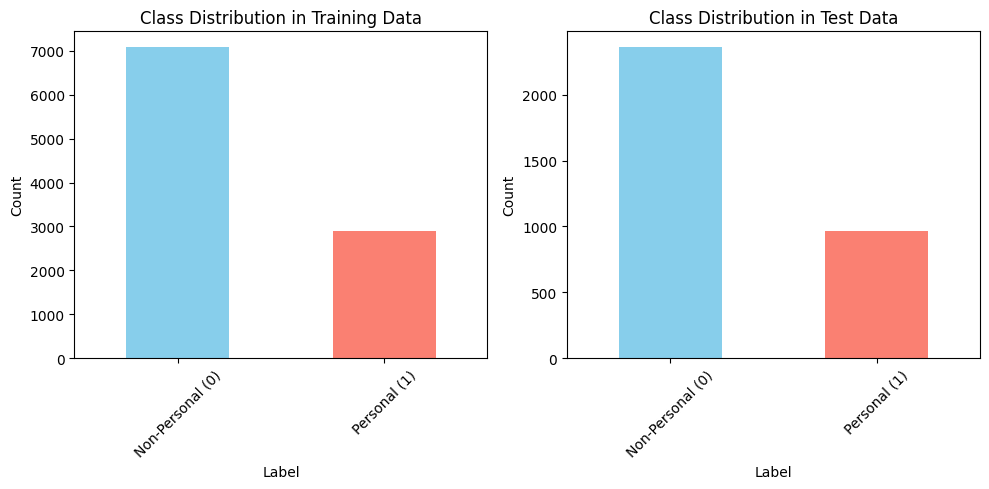

In [48]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
train_data['label'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution in Training Data')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Personal (0)', 'Personal (1)'], rotation=45)

plt.subplot(1, 2, 2)
test_data['label'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution in Test Data')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Personal (0)', 'Personal (1)'], rotation=45)

plt.tight_layout()
plt.show()

## 4. Data Preprocessing

In [49]:
import nltk
nltk.download('stopwords')
english_stops = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [50]:
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [51]:
print("Preprocessing tweets...")
train_data['cleaned_tweet'] = train_data['tweet'].apply(preprocess_text)
test_data['cleaned_tweet']  = test_data['tweet'].apply(preprocess_text)

print("\nExample of original vs cleaned tweets:")
for i in range(3):
    print(f"\nOriginal: {train_data['tweet'].iloc[i]}")
    print(f"Cleaned:  {train_data['cleaned_tweet'].iloc[i]}")

Preprocessing tweets...

Example of original vs cleaned tweets:

Original: user_mention all i can tell you is i have had few relapses on it it is not a cure i hear if you dont test for the jc virus tysabri is good
Cleaned:  user mention all i can tell you is i have had few relapses on it it is not a cure i hear if you dont test for the jc virus tysabri is good

Original: my doctor told me stop he gave me sum pop i mix it up w some adderall and wait to get to the top i mix it up w some alcohol pour
Cleaned:  my doctor told me stop he gave me sum pop i mix it up w some adderall and wait to get to the top i mix it up w some alcohol pour

Original: i take tylenol and i wake up in the middle of the night to put my ice pack on my belly and back for a couple of seconds so i can sleep
Cleaned:  i take tylenol and i wake up in the middle of the night to put my ice pack on my belly and back for a couple of seconds so i can sleep


In [ ]:
from sklearn.model_selection import train_test_split

X_train_all = train_data['cleaned_tweet'].values
y_train_all = train_data['label'].values
X_test      = test_data['cleaned_tweet'].values
y_test      = test_data['label'].values

# 15 % of training data becomes the validation set (stratified to preserve class ratio)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_all, y_train_all,
    test_size=0.15,
    random_state=42,
    stratify=y_train_all
)

print(f"Training samples:   {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples:       {len(X_test)}")


Training samples:   8492
Validation samples: 1499
Test samples:       3331  (held out — not used until final evaluation)


## 5. Tokenization and Padding

In [53]:
def get_max_length(texts):
    lengths = [len(t.split()) for t in texts]
    return int(np.ceil(np.mean(lengths) + np.std(lengths)))

max_length = get_max_length(X_train)
print(f"Maximum sequence length: {max_length}")

Maximum sequence length: 23


In [ ]:
MAX_WORDS = 10000

tokenizer = Tokenizer(num_words=MAX_WORDS, lower=True, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_pad = pad_sequences(tokenizer.texts_to_sequences(X_train),
                             maxlen=max_length, padding='post', truncating='post')
X_val_pad   = pad_sequences(tokenizer.texts_to_sequences(X_val),
                             maxlen=max_length, padding='post', truncating='post')
X_test_pad  = pad_sequences(tokenizer.texts_to_sequences(X_test),
                             maxlen=max_length, padding='post', truncating='post')

print(f"Vocabulary size:  {len(tokenizer.word_index)}")
print(f"X_train shape:    {X_train_pad.shape}")
print(f"X_val shape:      {X_val_pad.shape}")
print(f"X_test shape:     {X_test_pad.shape}")


Vocabulary size:  11648
X_train shape:    (8492, 23)
X_val shape:      (1499, 23)
X_test shape:     (3331, 23)


## 6. Load GloVe-Twitter Pretrained Embeddings

GloVe-Twitter was trained on **2 billion tweets** with 27 billion tokens.
Using it instead of a randomly initialized embedding layer gives the model
semantic knowledge it simply cannot learn from 10k training samples alone.

Download: https://nlp.stanford.edu/projects/glove/  
File needed: `glove.twitter.27B.100d.txt` (inside `glove.twitter.27B.zip`)

Upload it to your Google Drive and set `GLOVE_PATH` below.

In [ ]:
import numpy as np
import os

if not os.path.exists('glove.twitter.27B.zip'):
    print("Downloading GloVe embeddings (this may take a minute)...")
    !wget http://nlp.stanford.edu/data/glove.twitter.27B.zip
    print("Unzipping...")
    !unzip -q glove.twitter.27B.zip
    print("Done!")
else:
    print("GloVe files already downloaded.")

GLOVE_PATH    = 'glove.twitter.27B.100d.txt' 
EMBEDDING_DIM = 100  

print("Loading GloVe embeddings into dictionary...")
glove_index = {}
with open(GLOVE_PATH, encoding='utf-8') as f:
    for line in f:
        parts = line.split()
        word  = parts[0]
        try:
            glove_index[word] = np.array(parts[1:], dtype='float32')
        except ValueError:
            continue
            
print(f"Loaded {len(glove_index):,} GloVe word vectors")

word_index     = tokenizer.word_index
vocab_size     = min(MAX_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

found, missed = 0, 0
for word, idx in word_index.items():
    if idx >= MAX_WORDS:
        continue
    # vector lookup
    vec = glove_index.get(word)
    if vec is not None:
        embedding_matrix[idx] = vec
        found += 1
    else:
        missed += 1

print(f"Words found in GloVe:  {found:,}")
print(f"Words NOT in GloVe:    {missed:,}  (will use zero vectors)")
print(f"Embedding matrix shape: {embedding_matrix.shape}")

GloVe files already downloaded.
Loading GloVe embeddings into dictionary...
Loaded 1,193,514 GloVe word vectors
Words found in GloVe:  8,935
Words NOT in GloVe:    1,064  (will use zero vectors)
Embedding matrix shape: (10001, 100)


## 7. BiLSTM + Attention Model

In [ ]:
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(name='att_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = tf.nn.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        e = tf.squeeze(e, axis=-1)
        alpha = tf.nn.softmax(e)
        context = tf.reduce_sum(x * tf.expand_dims(alpha, -1), axis=1)
        return context

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

In [ ]:
LSTM_UNITS   = 32
DROPOUT_RATE = 0.5
L2_REG       = 0.001
EPOCHS       = 20
BATCH_SIZE   = 64

In [ ]:
inputs = Input(shape=(max_length,), name='input_layer')

x = Embedding(
    input_dim=vocab_size,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=max_length,
    trainable=True,
    name='glove_embedding'
)(inputs)

x = SpatialDropout1D(DROPOUT_RATE, name='spatial_dropout')(x)

x = Bidirectional(LSTM(
    LSTM_UNITS,
    return_sequences=True,
    dropout=DROPOUT_RATE,
    recurrent_dropout=0.4,
    kernel_regularizer=l2(L2_REG),
    recurrent_regularizer=l2(L2_REG),
    name='bilstm_layer'
), name='bidirectional')(x)

x = AttentionLayer(name='attention')(x)

x = Dense(64, activation='relu',
          kernel_regularizer=l2(L2_REG),
          name='dense_1')(x)
x = Dropout(DROPOUT_RATE, name='dropout')(x)

outputs = Dense(1, activation='sigmoid', name='output_layer')(x)

model = Model(inputs=inputs, outputs=outputs, name='BiLSTM_Attention_Model')

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "BiLSTM_Attention_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 23)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ glove_embedding (Embedding)     │ (None, 23, 100)        │     1,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout                 │ (None, 23, 100)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 23, 64)         │        34,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (AttentionLayer)      │ (None, 64)             │            87 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,038,460 (3.96 MB)

 Trainable params: 1,038,460 (3.96 MB)

 Non-trainable params: 0 (0.00 B)

None


## 8. Model Training

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_bilstm_attention_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=0.00001,
    verbose=1
)


In [60]:
print("Training BiLSTM + Attention model...")
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    verbose=1
)


Training BiLSTM + Attention model...
Epoch 1/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.6626 - loss: 0.9188
Epoch 1: val_accuracy improved from -inf to 0.71314, saving model to best_bilstm_attention_model.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 26s 99ms/step - accuracy: 0.6628 - loss: 0.9181 - val_accuracy: 0.7131 - val_loss: 0.6524 - learning_rate: 0.0010
Epoch 2/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7314 - loss: 0.6637
Epoch 2: val_accuracy improved from 0.71314 to 0.83189, saving model to best_bilstm_attention_model.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.7316 - loss: 0.6634 - val_accuracy: 0.8319 - val_loss: 0.4908 - learning_rate: 0.0010
Epoch 3/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7716 - loss: 0.5630
Epoch 3: val_accuracy improved from 0.83189 to 0.83856, saving model to best_bilstm_attention_model.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - accuracy: 0.7717 - loss: 0.5628 - val_accuracy: 0.8386 - val_loss: 0.4523 - learning_rate: 0.0010
Epoch 4/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7981 - loss: 0.5035
Epoch 4: val_accuracy improved from 0.83856 to 0.84390, saving model to best_bilstm_attention_model.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.7982 - loss: 0.5034 - val_accuracy: 0.8439 - val_loss: 0.4278 - learning_rate: 0.0010
Epoch 5/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8186 - loss: 0.4673
Epoch 5: val_accuracy improved from 0.84390 to 0.85924, saving model to best_bilstm_attention_model.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - accuracy: 0.8186 - loss: 0.4672 - val_accuracy: 0.8592 - val_loss: 0.3955 - learning_rate: 0.0010
Epoch 6/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8318 - loss: 0.4346
Epoch 6: val_accuracy improved from 0.85924 to 0.86057, saving model to best_bilstm_attention_model.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.8318 - loss: 0.4346 - val_accuracy: 0.8606 - val_loss: 0.3887 - learning_rate: 0.0010
Epoch 7/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8464 - loss: 0.4067
Epoch 7: val_accuracy improved from 0.86057 to 0.86124, saving model to best_bilstm_attention_model.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.8464 - loss: 0.4067 - val_accuracy: 0.8612 - val_loss: 0.3757 - learning_rate: 0.0010
Epoch 8/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8433 - loss: 0.3974
Epoch 8: val_accuracy did not improve from 0.86124
133/133 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - accuracy: 0.8433 - loss: 0.3974 - val_accuracy: 0.8559 - val_loss: 0.3815 - learning_rate: 0.0010
Epoch 9/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8542 - loss: 0.3785
Epoch 9: val_accuracy did not improve from 0.86124
133/133 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.8542 - loss: 0.3785 - val_accuracy: 0.8566 - val_loss: 0.3713 - learning_rate: 0.0010
Epoch 10/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8576 - loss: 0.3657
Epoch 10: val_accuracy did not improve from 0.86124
133/133 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.8576 - loss: 0.3657 - val_accuracy: 0.8579 - val_loss: 0.3706 - learning_rate: 0.0010
Epoch 11/20
1

## 9. Model Evaluation

In [ ]:
best_model = load_model(
    'best_bilstm_attention_model.h5',
    custom_objects={'AttentionLayer': AttentionLayer}
)

val_loss, val_accuracy   = best_model.evaluate(X_val_pad,  y_val,  verbose=0)
test_loss, test_accuracy = best_model.evaluate(X_test_pad, y_test, verbose=1)

print(f"\nTraining Loss:     {history.history['loss'][-1]:.4f}")
print(f"Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Validation Loss:   {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Loss:         {test_loss:.4f}")
print(f"Test Accuracy:     {test_accuracy:.4f}")
print(f"\nGeneralization gap (val → test): {val_accuracy - test_accuracy:.4f}")


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8206 - loss: 0.4378

Training Loss:     0.2856
Training Accuracy: 0.8921
Validation Loss:   0.3757
Validation Accuracy: 0.8612
Test Loss:         0.3928
Test Accuracy:     0.8430

Generalization gap (val → test): 0.0183


In [62]:
y_pred_proba = best_model.predict(X_test_pad)
y_pred       = (y_pred_proba > 0.5).astype(int).flatten()

from sklearn.metrics import classification_report, roc_auc_score

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Personal (0)', 'Personal (1)']))

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step

Classification Report:
                  precision    recall  f1-score   support

Non-Personal (0)       0.86      0.93      0.89      2364
    Personal (1)       0.78      0.64      0.70       967

        accuracy                           0.84      3331
       macro avg       0.82      0.78      0.80      3331
    weighted avg       0.84      0.84      0.84      3331


ROC-AUC Score: 0.9074


## 10. Training History Visualization

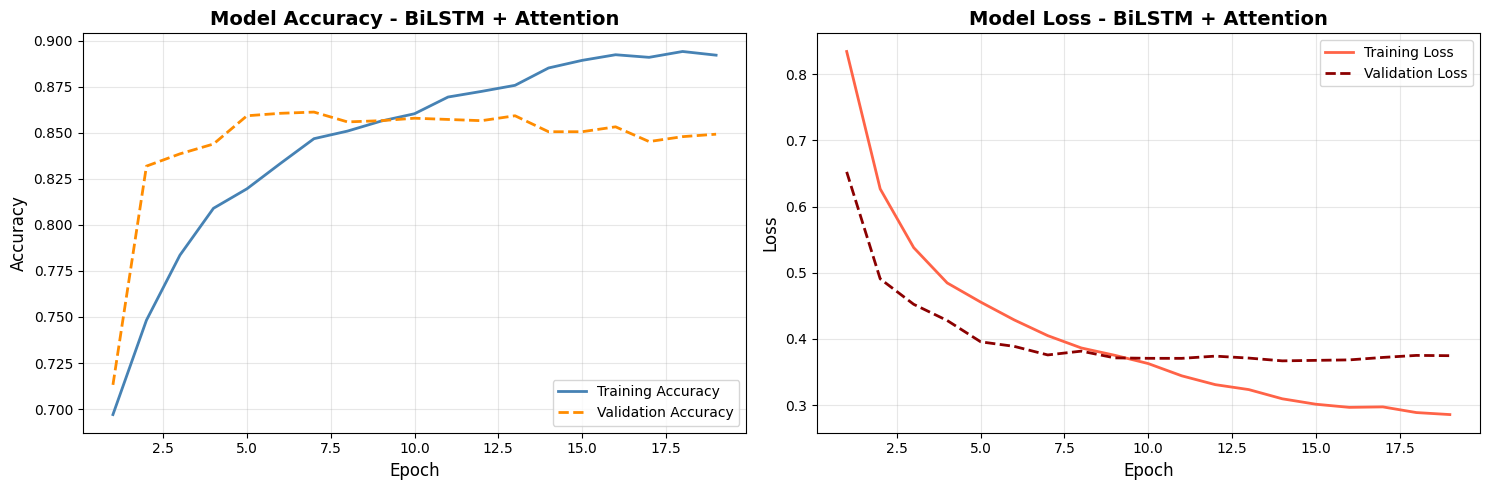


Training stopped at epoch 19 / 20


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

epochs_ran = range(1, len(history.history['accuracy']) + 1)

axes[0].plot(epochs_ran, history.history['accuracy'],
             label='Training Accuracy', linewidth=2, color='steelblue')
axes[0].plot(epochs_ran, history.history['val_accuracy'],
             label='Validation Accuracy', linewidth=2, color='darkorange', linestyle='--')
axes[0].set_title('Model Accuracy - BiLSTM + Attention', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

axes[1].plot(epochs_ran, history.history['loss'],
             label='Training Loss', linewidth=2, color='tomato')
axes[1].plot(epochs_ran, history.history['val_loss'],
             label='Validation Loss', linewidth=2, color='darkred', linestyle='--')
axes[1].set_title('Model Loss - BiLSTM + Attention', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('bilstm_attention_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nTraining stopped at epoch {len(epochs_ran)} / {EPOCHS}")
